In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import math
import types
from functools import reduce
from yahoo_fin.stock_info import *
import pandas_datareader.data as pdr
import yfinance as yf
from BackTestAlgo import *
from Order import *
from DataQuery import *
from Record import *
from AlphaBeta import *
from Preprocessing import *

In [3]:
def my_init(context):
    data = pd.read_csv('C:/Users/ajcltm/PycharmProjects/BackTesting/data/stock_price_data_KOSPI.csv')
    tickers = data['symbol'].unique().tolist()
    context.symbols = tickers
    # universe를 symbols로 정의(반드시 지정해야함)

    context.price = 'Adj Close'
    # price로 사용할 칼럼 인덱스 이름을 알려줘야함(open, high, close 등의 인덱스를 price로 활용 가능함)
    # 여기서 지정한 인덱스는 포트폴리오를 평가할 때 기본적으로 사용하는 지표임

    context.capital_base = 50000000
    # 투자원금을 설정함. 지정하지 않으면 기본값을 사용함

    # context.market_benchmark = 'SP500'
    # 지정하면 win_rate 계산 시에 비교, 지정 안하면 절대수익(0%와 비교)으로 계산

    context.i = 0

In [4]:
def handle_data(context, data):
    context.i += 1
    print('\n')
    print(data.current_time)

    if context.i == 1:
        p1 = pd.read_csv('C:/Users/ajcltm/Desktop/p1.csv', index_col=0)
        tickers = p1.tickers.apply(lambda x: '{:06d}'.format(x))
        s = {'ticker': [], 'price': []}
        f = {'ticker': [], 'price': []}
        for ticker in tickers:
            try:
                price = data.current_data('{}.KS'.format(ticker), 'Adj Close')
                s['ticker'].append('{}.KS'.format(ticker))
                s['price'].append(price)
            except:
                f['ticker'].append(ticker)
                f['price'].append(0)
        quantity = list(map(lambda x: int((50000000/len(s['price'])) / x), s['price']))
        order(context, s['ticker'], s['price'], quantity)

    bench_return = context.benchmark['benchmark_class'].benchmark_history(context, context.benchmark['benchmark_symbols'], 'return', 1).values[0]

    record(context, bench_return=bench_return)

In [5]:
data = pd.read_csv('C:/Users/ajcltm/PycharmProjects/BackTesting/data/stock_price_data_KOSPI_fixed.csv')
data = data.reset_index(drop=True)
data = data.sort_values(by='date')
data['date'] = pd.to_datetime(data['date'])
data = data.loc[data['date'] > datetime.datetime(2020, 5, 24)]

yf.pdr_override()

start_date = '25-05-2020'
end_date = '18-07-2021'

start = datetime.datetime.strptime(start_date, '%d-%m-%Y')
end = datetime.datetime.strptime(end_date, '%d-%m-%Y')

temp_data = pdr.get_data_yahoo('^KS11', data_source='yahoo', start=start, end=end)

temp_data['date'] = temp_data.index
temp_data = temp_data.reset_index(drop=True)
temp_data = temp_data.rename(columns={'Adj Close': 'price'})
temp_data['benchmark'] = 'kospi_200'
benchmark = temp_data

tester = BackTester(initialize=my_init, tradingAlgo=handle_data)

result = tester.run(data, benchmark)

pd.set_option('display.max.columns', 50)
pd.set_option('display.max_rows', 1000)

[*********************100%***********************]  1 of 1 completed

Hello backtesting


2020-05-25 00:00:00


C:\Users\ajcltm\PycharmProjects\BackTesting\BackTestAlgo.py:172: RuntimeWarning: invalid value encountered in double_scalars
  sharp_ratio = annualized_return / std_y
C:\Users\ajcltm\PycharmProjects\BackTesting\BackTestAlgo.py:173: RuntimeWarning: invalid value encountered in double_scalars
  roll_sharp_ratio = roll_annualized_return / roll_std_y




2020-05-26 00:00:00


2020-05-27 00:00:00


2020-05-28 00:00:00


2020-05-29 00:00:00


2020-06-01 00:00:00


2020-06-02 00:00:00


2020-06-03 00:00:00


2020-06-04 00:00:00


2020-06-05 00:00:00


2020-06-08 00:00:00


2020-06-09 00:00:00


2020-06-10 00:00:00


2020-06-11 00:00:00


2020-06-12 00:00:00


2020-06-15 00:00:00


2020-06-16 00:00:00


2020-06-17 00:00:00


2020-06-18 00:00:00


2020-06-19 00:00:00


2020-06-22 00:00:00


2020-06-23 00:00:00


2020-06-24 00:00:00


2020-06-25 00:00:00


2020-06-26 00:00:00


2020-06-29 00:00:00


2020-06-30 00:00:00


2020-07-01 00:00:00


2020-07-02 00:00:00


2020-07-03 00:00:00


2020-07-06 00:00:00


2020-07-07 00:00:00


2020-07-08 00:00:00


2020-07-09 00:00:00


2020-07-10 00:00:00


2020-07-13 00:00:00


2020-07-14 00:00:00


2020-07-15 00:00:00


2020-07-16 00:00:00


2020-07-17 00:00:00


2020-07-20 00:00:00


2020-07-21 00:00:00


2020-07-22 00:00:00


2020-07-23 00:00:00


2020-07-24 00:00:00


2020-07-27 00:00:00


2020-07-

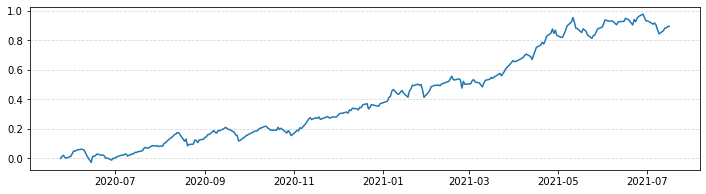

In [6]:
plt.figure(figsize=(12,3))
plt.plot(result['date'], result['cumulative_return'])
plt.grid(axis='y', linestyle='--', alpha=.5)

cumulative_benchmark_return : 1.64
cumulateive_portfolio_return : 1.89


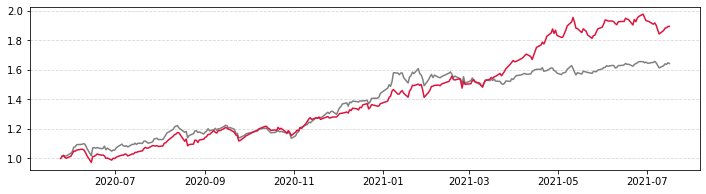

In [7]:
cul_bench_return = result['bench_return'].add(1).cumprod()
cul_portfolio_return = result['portfolio_return'].add(1).cumprod()

plt.figure(figsize=(12,3))
plt.plot(result['date'], cul_bench_return, c='gray')
plt.plot(result['date'], cul_portfolio_return, c='crimson')
plt.grid(axis='y', linestyle='--', alpha=.5)
print(f'cumulative_benchmark_return : {math.floor(cul_bench_return.iloc[-1]*100)/100}')
print('cumulateive_portfolio_return : %.2f' %cul_portfolio_return.iloc[-1])

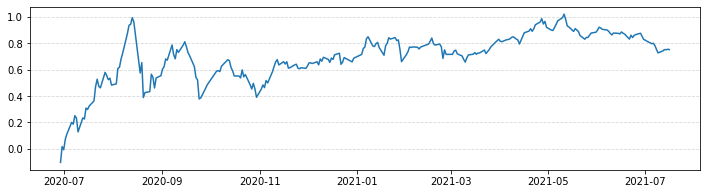

In [8]:
plt.figure(figsize=(12,3))
plt.plot(result['date'].iloc[25:], result['annualized_return'].iloc[25:])
plt.grid(axis='y', linestyle='--', alpha=.5)

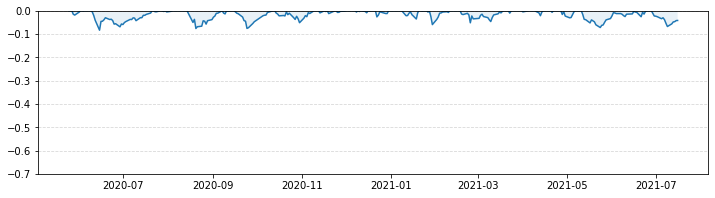

In [9]:
plt.figure(figsize=(12,3))
plt.plot(result['date'], result['drawdown_ratio'])
plt.fill_between(result['date'], result['drawdown_ratio'], result['drawdown_ratio'].max(), alpha=.1)
plt.ylim(-.7,0)
plt.grid(axis='y', linestyle='--', alpha=.5)

[1.         1.0110664  0.99295775 0.98390342 0.98390342 0.99094567
 0.98792757 0.99195171 0.98591549 0.9889336  0.99094567 0.99195171
 0.97484909 0.96981891 0.96881288 0.94567404 0.95975855 0.95573441
 0.96981891 1.06639839 1.02615694 0.98088531 1.01609658 0.9778672
 0.9778672  0.95573441 0.95372233 0.95171026 0.95472837 0.95875252
 0.95975855 0.94466801 0.95171026 0.95171026 0.94969819 0.95975855
 0.95774648 0.95573441 0.95573441 0.9637827  0.96881288 0.96177062
 0.97987928 0.96881288 0.96177062 0.96780684 0.97082495 0.97283702
 0.97585513 0.97484909 0.97484909 0.97283702 0.96478873 0.97183099
 0.98692153 0.98792757 1.02615694 1.0110664  1.02112676 1.0110664
 0.97082495 0.97283702 0.94567404 0.96478873 0.96780684 0.99698189
 0.99597586 0.97585513 0.99899396 1.00100604 0.99295775 1.00301811
 1.         0.97585513 0.98591549 0.97686117 0.96981891 0.97384306
 0.97384306 0.97283702 0.98591549 0.97484909 0.97183099 0.97484909
 0.9637827  0.97887324 0.97384306 0.95573441 0.95372233 0.958752

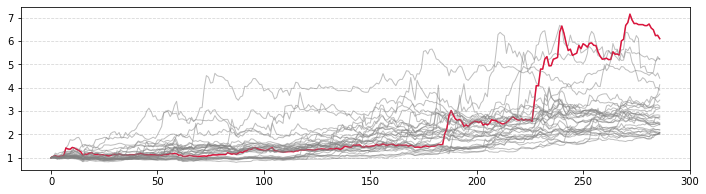

In [31]:
import sklearn
from sklearn.preprocessing import *

p1 = pd.read_csv('C:/Users/ajcltm/Desktop/p1.csv', index_col=0)
tickers = p1.tickers.apply(lambda x: '{:06d}.KS'.format(x))

old_price_details = {}
for ticker in tickers :
    old_price_details[ticker] = data[data['symbol']==ticker]['Adj Close'].values.reshape(-1)
    old_price_details[ticker] = old_price_details[ticker]/ old_price_details[ticker][0]
    
old_price_details_df = pd.DataFrame(data=old_price_details.values(), index=old_price_details.keys())
old_top = old_price_details_df.sort_values(by=old_price_details_df.columns[-1], ascending=False).iloc[:1].index.tolist()    
print(old_price_details['004090.KS'])
print(len(old_price_details['004090.KS']))

print('total   : {0}'.format(len(tickers)))
plt.figure(figsize=(12,3))
num = 0
thred = 2
old_tier1=[]
for ticker in tickers :
    if old_price_details[ticker][-1] > thred :
        plt.plot(old_price_details[ticker], linewidth=1, c='grey', alpha=.5)
        plt.grid(axis='y', linestyle='--', alpha=.5)
        num+=1
        old_tier1.append(ticker)
    if ticker in old_top : 
        plt.plot(old_price_details[ticker], c='crimson', linewidth=1.5, alpha=1)
        plt.grid(axis='y', linestyle='--', alpha=.5)

print('{0}  >  : {1} ({2})'.format(thred, num, round(num/len(tickers),2)))

num = 0
thred_upper = 2
thred_down = 1.5
for ticker in tickers :
    if old_price_details[ticker][-1] > thred_down and old_price_details[ticker][-1] < thred_upper:
        num+=1
print('{0}  >  > {1} : {2} ({3})'.format(thred_upper, thred_down, num, round(num/len(tickers),2)))

num = 0
thred_upper = 1.5
thred_down = 1.2
for ticker in tickers :
    if old_price_details[ticker][-1] > thred_down and old_price_details[ticker][-1] < thred_upper:
        num+=1
print('{0}  >  > {1} : {2} ({3})'.format(thred_upper, thred_down, num, round(num/len(tickers),2)))

num = 0
thred_upper = 1.2
thred_down = 1
for ticker in tickers :
    if old_price_details[ticker][-1] > thred_down and old_price_details[ticker][-1] < thred_upper:
        num+=1
print('{0}  >  > {1} : {2} ({3})'.format(thred_upper, thred_down, num, round(num/len(tickers),2)))

total   : 119
2  >  : 30 (0.25)
2  >  > 1.5 : 47 (0.39)
1.5  >  > 1.2 : 31 (0.26)
1.2  >  > 1 : 9 (0.08)


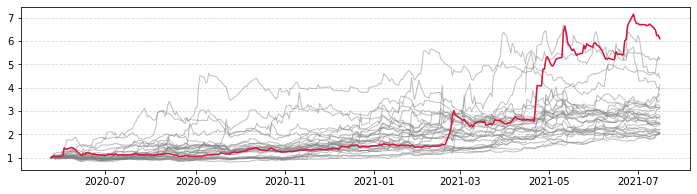

In [116]:
p1 = pd.read_csv('C:/Users/ajcltm/Desktop/p1.csv', index_col=0)
tickers = p1.tickers.apply(lambda x: '{:06d}.KS'.format(x))

price_details = [data.loc[data['symbol']==ticker, ['date', 'Adj Close']] for ticker in tickers]
price_details_df = reduce(lambda x, y : pd.merge(x, y, how='outer', on='date'), price_details)
price_details_df.columns = ['date']+tickers.tolist()
price_details_df = price_details_df.drop('date', axis=1)

for ticker in tickers :
    price_details_df[ticker] = price_details_df.loc[:,ticker].apply(lambda x : x/price_details_df.loc[:,ticker][0])
    
top = price_details_df.T.sort_values(by=price_details_df.index[-1], ascending=False).iloc[:1].index.tolist()

tier1=price_details_df.iloc[-1][price_details_df.iloc[-1]>2].index.tolist()
tier=[len(price_details_df.iloc[-1][price_details_df.iloc[-1]>thred].index.tolist()) for thred in [2,1.5,1.2,1]]
plt.figure(figsize=(12,3))
plt.plot(result['date'], price_details_df[tier1], linewidth=1, c='grey', alpha=.5)
plt.plot(result['date'], price_details_df[top], c='crimson', linewidth=1.5, alpha=1)
plt.grid(axis='y', linestyle='--', alpha=.5)
print('total   : {0}'.format(len(tickers)))
print('{0}  >  : {1} ({2})'.format(2, tier[0], round(tier[0]/len(tickers),2)))
print('{0}  >  > {1} : {2} ({3})'.format(2, 1.5, tier[1]-tier[0], round((tier[1]-tier[0])/len(tickers),2)))
print('{0}  >  > {1} : {2} ({3})'.format(1.5, 1.2, tier[2]-tier[1], round((tier[2]-tier[1])/len(tickers),2)))
print('{0}  >  > {1} : {2} ({3})'.format(1.2, 1, tier[3]-tier[2], round((tier[3]-tier[2])/len(tickers),2)))

In [134]:
price_details_df

,001230.KS,013580.KS,012630.KS,004960.KS,002030.KS,001940.KS,000590.KS,015230.KS,036530.KS,004560.KS,002460.KS,084010.KS,294870.KS,009970.KS,013570.KS,003300.KS,002170.KS,002020.KS,032560.KS,092230.KS,072710.KS,007340.KS,003650.KS,004490.KS,012320.KS,...,006110.KS,001130.KS,117580.KS,017940.KS,001460.KS,005740.KS,009830.KS,004000.KS,227840.KS,058850.KS,003240.KS,003570.KS,006360.KS,004250.KS,213500.KS,136490.KS,023530.KS,102260.KS,241560.KS,036460.KS,005880.KS,016740.KS,005820.KS,004360.KS,005850.KS
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN
1,1.064356,1.043614,0.985294,1.034351,1.004963,1.040909,1.005964,0.997908,1.003333,1.030220,1.024631,1.047009,0.957082,1.003497,1.000000,1.007519,1.022472,1.038889,1.041667,1.000000,1.003713,1.003953,0.991597,1.041096,1.001887,...,1.030075,1.000000,1.000000,1.002717,1.002364,1.009901,1.055899,1.017687,1.000000,1.002703,1.000000,1.022222,1.122661,1.008152,0.993220,1.044852,1.009206,1.003488,1.000000,1.019713,1.011364,1.023897,0.996998,1.014563,NaN
2,1.089109,1.080997,0.980392,1.083969,0.995037,1.036364,1.017893,1.002092,1.006667,1.031593,1.068966,1.052707,0.944206,1.003497,0.997653,1.011815,1.007491,1.016667,1.048334,0.996595,1.007426,1.021739,0.973109,1.017123,1.003774,...,1.035088,0.996310,1.001046,1.028533,0.995272,1.013201,1.040371,1.047619,1.000000,1.000000,1.010638,1.027778,1.164241,1.013587,1.010169,1.024465,1.014960,1.000000,1.038961,1.044803,1.031250,1.069853,0.993996,1.014563,NaN
3,1.075495,1.043614,0.964706,1.053435,0.998759,1.031818,1.003976,0.991632,0.993333,1.008242,1.044335,1.047009,0.907725,0.991841,0.971831,1.011815,0.983146,0.994444,1.018334,0.989784,0.972772,1.023715,0.969748,0.998288,1.003774,...,1.003759,0.981550,0.995816,1.017663,0.985816,0.996700,1.012424,1.035374,1.000000,1.067568,1.003989,1.001852,1.162162,1.000000,0.989831,0.998981,1.006904,0.996512,1.017316,1.044803,1.008523,1.071691,0.990995,1.014563,NaN
4,1.055693,1.074766,0.931373,1.068702,0.998759,1.040909,0.988072,0.987448,0.986667,1.009615,1.064039,1.052707,0.856223,0.970862,0.954225,1.008593,1.005618,0.966667,1.005000,0.996595,0.944307,0.970356,0.966387,0.982877,0.998113,...,1.006266,0.981550,1.001046,0.968750,0.978723,0.993399,1.003104,1.029932,0.994030,1.027027,0.984043,1.000000,1.187110,1.012228,0.979661,1.015291,1.024166,0.996512,1.025974,1.069892,0.982955,1.084559,0.987993,1.004854,NaN
5,1.061881,1.074766,0.932353,1.064885,0.997519,1.077273,0.992048,0.991632,1.010000,1.016484,1.068966,1.049858,0.864807,1.000000,0.974178,1.016112,1.011236,0.983333,1.023334,0.996595,0.975248,1.021739,0.973109,1.003425,1.001887,...,1.022556,0.996310,1.015690,0.997283,0.988180,1.004400,1.043475,1.039456,1.000000,1.021622,1.000000,1.005556,1.193347,1.019022,0.976271,1.034659,1.023015,0.995349,1.054113,1.050179,0.994318,1.102941,1.000000,0.975728,NaN
6,1.089109,1.080997,0.955882,1.072519,0.998759,1.095455,1.288270,0.993724,1.063333,1.028846,1.049261,1.031339,0.875536,1.036131,0.971831,1.015038,1.014981,1.011111,1.033334,1.001135,0.988861,1.027668,0.973109,1.013699,1.033962,...,1.040100,1.000000,1.020921,1.019022,0.992908,0.996700,1.055899,1.036735,1.014925,1.056757,0.997340,1.016667,1.199584,0.991848,1.027119,1.024465,1.035673,0.994186,1.093074,1.057348,1.000000,1.130515,1.003008,1.000000,NaN
7,1.415842,1.093458,0.980392,1.091603,0.996278,1.127273,1.345924,1.077406,1.043333,1.104396,1.054187,1.091168,0.890558,1.003497,0.990610,1.019334,1.043071,1.016667,1.108333,1.002270,0.975248,1.045455,0.978151,1.034247,1.037736,...,1.047619,0.985240,1.019874,1.031250,0.990544,0.990099,1.071428,1.054422,1.039801,1.062162,1.035904,1.024074

In [50]:
result.columns

Index(['date', 'capital_base', 'starting_cash', 'ending_cash',
       'starting_stock_value', 'ending_stock_value',
       'starting_portfolio_value', 'ending_portfolio_value',
       'portfolio_return', 'annualized_return', 'roll_annualized_return',
       'volatility', 'roll_volatility', 'sharp_ratio', 'roll_sharp_ratio',
       'cumulative_return', 'drawdown_ratio', 'MDD', 'underwater_period',
       'win_rate', 'roll_win_rate', 'total_profit', 'alpha', 'beta_kospi_200',
       'bench_return'],
      dtype='object')

In [52]:
pd.set_option('display.float_format', '{:.2f}'.format) 
result[['date','portfolio_return', 'annualized_return', 'roll_annualized_return',
       'volatility', 'roll_volatility', 'sharp_ratio', 'roll_sharp_ratio',
       'cumulative_return']]

,date,portfolio_return,annualized_return,roll_annualized_return,volatility,roll_volatility,sharp_ratio,roll_sharp_ratio,cumulative_return
0,2020-05-25,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00
1,2020-05-26,0.01,4.43,4.43,0.11,0.11,41.28,41.28,0.01
2,2020-05-27,0.01,4.93,4.93,0.09,0.09,56.05,56.05,0.02
3,2020-05-28,-0.02,0.46,0.46,0.17,0.17,2.68,2.68,0.01
4,2020-05-29,-0.00,0.12,0.12,0.16,0.16,0.79,0.79,0.00
5,2020-06-01,0.01,0.89,0.89,0.16,0.16,5.53,5.53,0.02
6,2020-06-02,0.02,2.06,2.06,0.17,0.17,12.40,12.40,0.03
7,2020-06-03,0.02,3.72,3.72,0.17,0.17,21.68,21.68,0.05
8,2020-06-04,-0.00,2.84,2.84,0.17,0.17,17.07,17.07,0.05
9,2020-06-05,0.01,3.04,3.04,0.16,0.16,19.22,19.22,0.06


In [53]:
result[['date', 'drawdown_ratio', 'MDD', 'underwater_period',
       'win_rate', 'roll_win_rate', 'total_profit', 'alpha', 'beta_kospi_200',
       'bench_return']]

,date,drawdown_ratio,MDD,underwater_period,win_rate,roll_win_rate,total_profit,alpha,beta_kospi_200,bench_return
0,2020-05-25,0.00,0,0 days,0.00,0.00,0.00,NaN,NaN,NaN
1,2020-05-26,0.00,0,0 days,0.50,0.50,675910.33,0.01,0.00,0.02
2,2020-05-27,0.00,0,0 days,0.67,0.67,1070831.94,0.01,0.34,0.00
3,2020-05-28,-0.02,-0.02,1 days,0.50,0.50,299933.73,-0.00,1.05,-0.00
4,2020-05-29,-0.02,-0.02,2 days,0.40,0.40,116016.54,-0.00,1.06,0.00
5,2020-06-01,-0.01,-0.02,5 days,0.50,0.50,761020.83,-0.00,1.01,0.02
6,2020-06-02,0.00,-0.02,5 days,0.57,0.57,1578708.32,-0.00,1.09,0.01
7,2020-06-03,0.00,-0.02,5 days,0.62,0.62,2525793.90,-0.00,0.86,0.03
8,2020-06-04,-0.00,-0.02,5 days,0.56,0.56,2459261.13,-0.00,0.87,0.00
9,2020-06-05,0.00,-0.02,5 days,0.60,0.60,2846056.12,-0.00,0.85,0.01


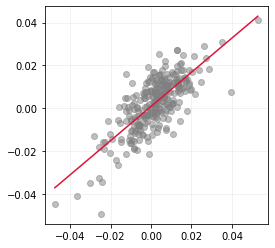

In [55]:
x_max=result['bench_return'].max()
x_min=result['bench_return'].min()
x = np.linspace(x_min, x_max, 100)
y = result['alpha'].values[-1] + result['beta_kospi_200'].values[-1]*x

plt.figure(figsize=(4,4))
plt.scatter(result['bench_return'], result['portfolio_return'],c='gray', alpha=.5)
plt.plot(x,y,c='crimson')
plt.grid(alpha=.2)

In [20]:
result.to_csv('C:/Users/ajcltm/Desktop/backtesting/result.csv')